# US Power Plants Map Visualization

This notebook downloads a public dataset of all US power plants, including their locations and types (nuclear, coal, natural gas, wind, solar, etc.), and plots them on a US map using matplotlib and cartopy. Different icons are used for each power type.

Dataset source: [EPA eGRID Open Data Portal](https://www.epa.gov/egrid/detailed-data)

In [ ]:
%pip install openpyxl

In [7]:
import pandas as pd
import requests
from io import BytesIO

print("Downloading EPA eGRID Excel file...")
egrid_url = "https://www.epa.gov/system/files/documents/2025-06/egrid2023_data_rev2.xlsx"
response = requests.get(egrid_url, stream=True)

if response.status_code != 200:
    raise Exception(f"Failed to download file: status code {response.status_code}")

print("Download complete. Reading Excel file...")

excel_data = BytesIO(response.content)

df = None
try:
    df = pd.read_excel(excel_data, sheet_name="PLNT23")
    print("Excel file loaded. Processing data...")
except Exception as e:
    print(f"Error reading Excel file: {e}")

if df is not None:
    print("Available columns:")
    print(list(df.columns))

    # Columns:
    name_col = "Plant name"
    # Find the correct column name for state (case or whitespace may differ)
    state_col = [col for col in df.columns if "state" in col.lower()][0] if any("state" in col.lower() for col in df.columns) else None
    lat_col = df.columns[19]  # Column T
    lon_col = df.columns[20]  # Column U
    fuel_col = df.columns[24] # Column Y

    if state_col is None:
        print("Could not find a column for state. Please check the column names above.")
    else:
        plants = df[[name_col, state_col, lat_col, lon_col, fuel_col]].copy()
        plants.columns = ["name", "state", "lat", "lon", "fuel"]

        # Fuzzy match fuel types
        def classify_fuel(fuel):
            fuel = str(fuel).strip().upper()
            if "NUC" in fuel or "NUCLEAR" in fuel:
                return "Nuclear"
            elif "COL" in fuel or "COAL" in fuel:
                return "Coal"
            elif "NG" in fuel or "NATURAL GAS" in fuel or "GAS" in fuel:
                return "Natural Gas"
            elif "WND" in fuel or "WIND" in fuel:
                return "Wind"
            elif "SUN" in fuel or "SOLAR" in fuel:
                return "Solar"
            else:
                return f"{fuel} - unknown"

        plants["fuel_type"] = plants["fuel"].apply(classify_fuel)

        print("Data processed. Showing first 10 rows:")
        display(plants.head(10))
else:
    print("No data loaded.")

Download complete. Reading Excel file...
Excel file loaded. Processing data...
Available columns:
['Plant file sequence number', 'Data Year', 'Plant state abbreviation', 'Plant name', 'DOE/EIA ORIS plant or facility code', 'Plant transmission or distribution system owner name', 'Plant transmission or distribution system owner ID', 'Utility name', 'Utility ID', 'Plant-level sector', 'Balancing Authority Name', 'Balancing Authority Code', 'NERC region acronym', 'eGRID subregion acronym', 'eGRID subregion name', 'Plant associated ISO/RTO Territory', 'Plant FIPS state code', 'Plant FIPS county code', 'Plant county name', 'Plant latitude', 'Plant longitude', 'CAPD Program Flag', 'Number of units', 'Number of generators', 'Plant primary fuel', 'Plant primary fuel category', 'Flag indicating if the plant burned or generated any amount of coal', 'Plant capacity factor', 'Plant nameplate capacity (MW)', 'Nonbaseload Factor', 'Biogas/ biomass plant adjustment flag', 'Combined heat and power (CHP

,name,state,lat,lon,fuel,fuel_type
0,PNAME,PSTATABB,LAT,LON,PLPRMFL,PLPRMFL - unknown
1,Alakanuk,AK,62.6833,-164.6544,DFO,DFO - unknown
2,Allison Creek Hydro,AK,61.084444,-146.353333,WAT,WAT - unknown
3,Ambler,AK,67.08798,-157.856719,DFO,DFO - unknown
4,Angoon,AK,57.499166,-134.58614,DFO,DFO - unknown
5,Aniak,AK,61.580678,-159.535643,DFO,DFO - unknown
6,Annex Creek,AK,58.3176,-134.101,WAT,WAT - unknown
7,Auke Bay,AK,58.3875,-134.6446,DFO,DFO - unknown
8,Aurora Energy LLC Chena,AK,64.847743,-147.735063,SUB,SUB - unknown
9,Barrow,AK,71.292,-156.7786,NG,Natural Gas


### To do
show list of fuel types unknown
categorize them
validate the map
have it cut for just nuclear, and a few others and eye ball it

/Users/matthewmartin/dream_machine/sandbox/power and maps/.venv/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/matthewmartin/dream_machine/sandbox/power and maps/.venv/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/matthewmartin/dream_machine/sandbox/power and maps/.venv/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/matthewmartin/dream_machine/sandbox/power and maps/.venv/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Down

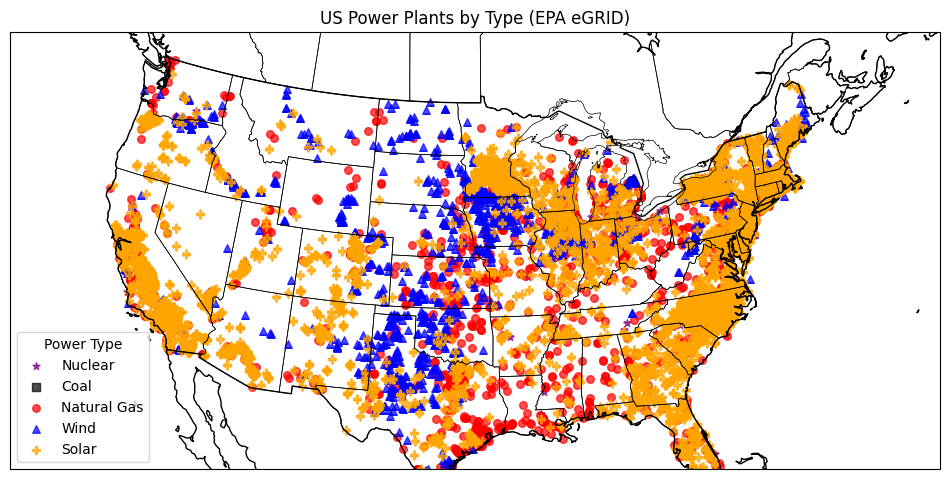

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Marker styles for each fuel type
marker_map = {
    "Nuclear": "*",
    "Coal": "s",
    "Natural Gas": "o",
    "Wind": "^",
    "Solar": "P"
}

color_map = {
    "Nuclear": "purple",
    "Coal": "black",
    "Natural Gas": "red",
    "Wind": "blue",
    "Solar": "orange"
}

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.LambertConformal())
ax.set_extent([-125, -66.5, 24, 50], crs=ccrs.Geodetic())
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

for fuel_type in marker_map.keys():
    subset = plants[plants["fuel_type"] == fuel_type]
    ax.scatter(subset["lon"], subset["lat"],
               color=color_map[fuel_type],
               marker=marker_map[fuel_type],
               label=fuel_type,
               s=30,
               alpha=0.7,
               transform=ccrs.Geodetic())

plt.legend(title="Power Type", loc="lower left")
plt.title("US Power Plants by Type (EPA eGRID)")
plt.show()